In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


data = pd.read_csv('transformer_data.csv')

data


,time,Y,Ta,S,I
0,1,23.496733,7.083333,0.0,15.899541
1,2,22.720333,7.116667,0.0,15.861768
2,3,22.052700,7.216667,0.0,16.121469
3,4,21.538050,7.250000,0.0,15.447628
4,5,20.995033,7.316667,0.0,16.258319
...,...,...,...,...,...
163,164,31.510183,14.350000,157.5,16.000643
164,165,30.037760,12.166667,29.0,16.005937
165,166,28.530450,10.283333,0.0,16.427983
166,167,27.118660,8.700000,0.0,16.370292


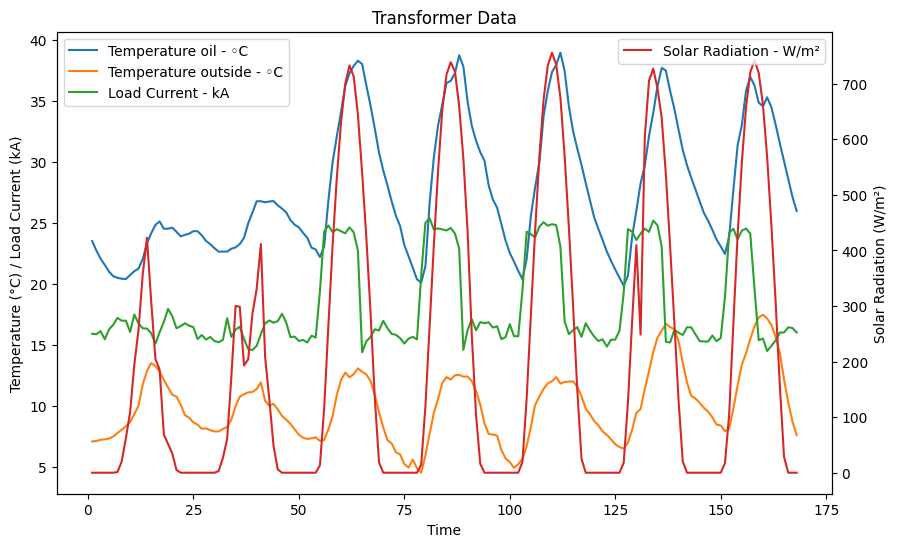

In [2]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis
ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')
ax1.plot(data["time"], data["Ta"], label="Temperature outside - ◦C", color='tab:orange')
ax1.plot(data["time"], data["I"], label="Load Current - kA", color='tab:green')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C) / Load Current (kA)")
ax1.legend(loc='upper left')

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(data["time"], data["S"], label="Solar Radiation - W/m²", color='tab:red')
ax2.set_ylabel("Solar Radiation (W/m²)")
ax2.legend(loc='upper right')

plt.title("Transformer Data")
plt.show()

### Briefly comment on patterns, trends, or correlations you observe.
• Hint: Look for relationships between temperature, outdoor conditions, and load.

You could initially think the oil temperature is rising because of solar radition, or the load is simply correlated with people using more power during the day hours where there is a higher outside temperature and more solar radition because the sun is out. How ever it seem that the load is much more coorelated with the sun radition, since load is not consistent with time of day (and outside temperature). You could speculate since there is such a strong correlation with solar radiation that the transformer station is connected to a solar farm and subsequently delivers (and transforms) much more power when the sun is out, and that the significant increases in oil heat is mostly correlated with load and not the outside temperature being hotter outside due to the sun being out.


In [ ]:
import numpy as np
from scipy.optimize import minimize

def return_1d_params(params):
    A = params[0]
    B = np.array(params[1:4]).reshape((1, 3))  # shape (1, 3)
    #sigma_1 = params[4]**2  # Q - system covariance (positive definite)
    sigma_1 = params[4] # Q - system covariance (positive definite)
    C = params[5]

    #sigma_2 = params[6]**2  # R - observation covariance (positive definite)
    sigma_2 = params[6] # R - observation covariance (positive definite)
    return A, B, sigma_1, C, sigma_2


def kf_log_likelihood_1d(params, df):
    # Extract parameters
    A, B, sigma_1, C, sigma_2 = return_1d_params(params)

    # Data
    Y = df['Y'].to_numpy()  # shape (T, 1)
    # print("Y shape:", Y.shape)
    # print(Y)
    U = df[['Ta', 'S', 'I']].to_numpy()  # shape (T, 3)
    Tn = len(Y)

    # Initialization
    x_est = 20  # shape (1, 1)
    P_est = np.eye(1) * 0.1
    log_likelihood = 0

    for t in range(Tn):
        # Prediction step
        x_pred = A * x_est + B @ U[t]  # shape (1,1)
        P_pred = A * P_est * A + sigma_1

        # Innovation step
        y_pred = C * x_pred
        S_t = C * P_pred * C + sigma_2
        innov = Y[t] - y_pred

        # Log-likelihood
        log_likelihood -= 0.5 * (np.log(2 * np.pi * S_t) + (innov ** 2) / S_t)

        # Update step
        K_t = P_pred * C / S_t
        x_est = x_pred + K_t * innov
        P_est = (1 - K_t * C) * P_pred

    return -log_likelihood.flatten()[0]

def estimate_dt(df, lower=None, upper=None):
    def neg_log_likelihood(par):
        return kf_log_likelihood_1d(par, df)
    
    np.random.seed(0)
    start_par = np.random.uniform(-1, 1, size=7)
    #var are [A, B1, B2, B3, sqrt(sigma_1), C, sqrt(sigma_2)]
    lower = [-10, -10, -10, -10, 0.001, -5, 0.001]
    upper = [10, 10, 10, 10, 10, 5, 5]
    result = minimize(
        neg_log_likelihood,
        x0=start_par,
        bounds=list(zip(lower, upper)) if lower is not None else None,
        method="L-BFGS-B",
        options={"maxiter": 1000, "disp": True}
    )
    return result

In [119]:
def kalman_predict_and_filter_1d(params, df):
    # Unpack estimated parameters
    A, B, sigma_1, C, sigma_2 = return_1d_params(params)

    # Data
    Y = df['Y'].to_numpy()
    U = df[['Ta', 'S', 'I']].to_numpy()
    Tn = len(Y)

    # Initialization
    x_est = 20 # initial filtered state
    P_est = np.eye(1) * 0.1
    x_filtered = []
    y_predicted = []

    for t in range(Tn):
        # --- Prediction step ---
        x_pred = A * x_est + B @ U[t]
        P_pred = A * P_est * A + sigma_1
        y_pred = C * x_pred  # predicted output
        y_predicted.append(y_pred.item())

        # --- Update step ---
        S_t = C * P_pred * C + sigma_2
        K_t = P_pred * C / S_t
        innovation = Y[t] - y_pred
        x_est = x_pred + K_t * innovation
        P_est = (1 - K_t * C) * P_pred
        x_filtered.append(x_est.item())

    return np.array(x_filtered), np.array(y_predicted)


In [121]:
results = estimate_dt(df=data)
params = results.x


In [122]:
print([param for param in zip(['A', 'B', 'sigma_1', 'C', 'sigma_2'],return_1d_params(params))])

[('A', 0.8010861284703743), ('B', array([[0.0841635 , 0.00237757, 0.17640783]])), ('sigma_1', 0.2821644794810487), ('C', 1.2094876366904128), ('sigma_2', 0.001)]


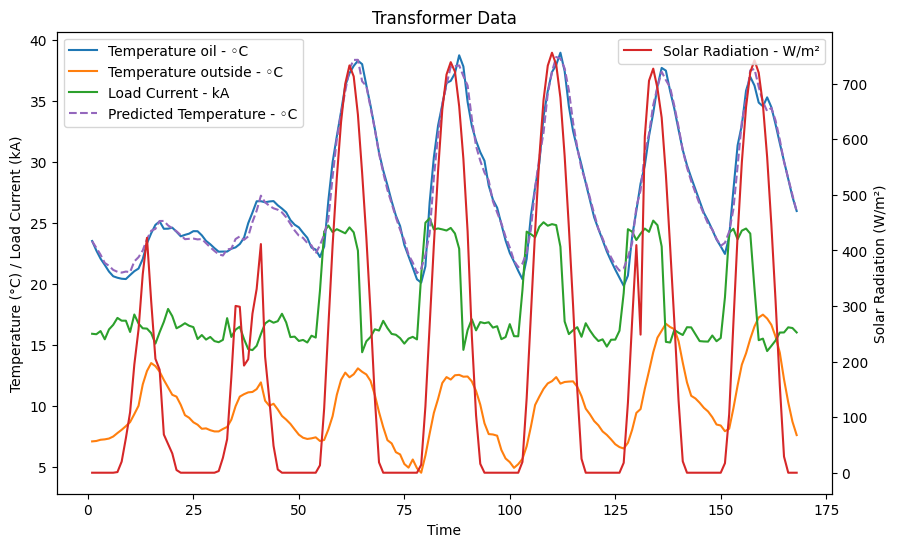

In [123]:
x_filtered, y_predicted = kalman_predict_and_filter_1d(params, data)
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis
ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')
ax1.plot(data["time"], data["Ta"], label="Temperature outside - ◦C", color='tab:orange')
ax1.plot(data["time"], data["I"], label="Load Current - kA", color='tab:green')
ax1.plot(data["time"], y_predicted, label="Predicted Temperature - ◦C", color='tab:purple', linestyle='--')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C) / Load Current (kA)")
ax1.legend(loc='upper left')

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(data["time"], data["S"], label="Solar Radiation - W/m²", color='tab:red')
ax2.set_ylabel("Solar Radiation (W/m²)")
ax2.legend(loc='upper right')

plt.title("Transformer Data")
plt.show()




In [133]:
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    aic = n * np.log(rss / n) + 2 * k
    bic = n * np.log(rss / n) + k * np.log(n)
    return aic, bic

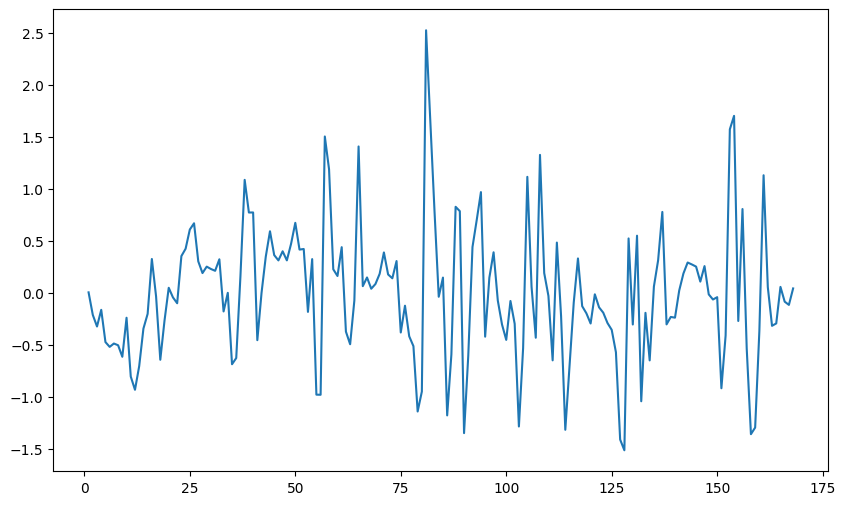

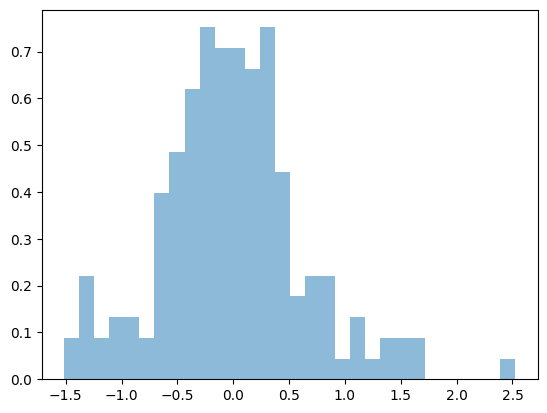

AIC: -134.38716047952838, BIC: -112.51941262370556


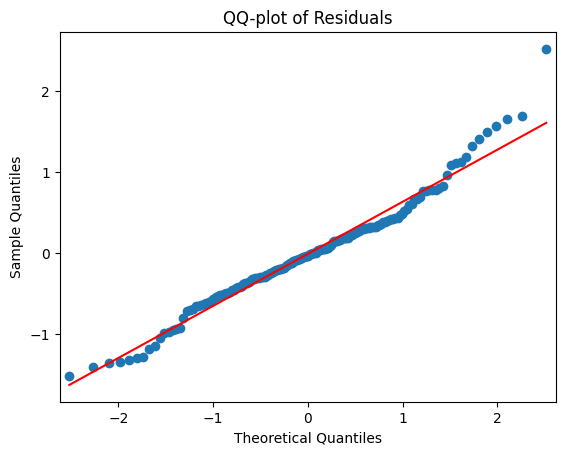

In [136]:
#plot_acf(y_predicted, lags=50)
#plot_pacf(y_predicted, lags=50)

#plot residuals
plt.figure(figsize=(10, 6))
plt.plot(data["time"], data["Y"] - y_predicted, label="Residuals", color='tab:blue')
plt.show()

#residual histogram
plt.hist(data["Y"] - y_predicted, bins=30, alpha=0.5, color='tab:blue', density=True)
plt.show()

# QQ-plot
import scipy.stats as stats
import statsmodels.api as sm
sm.qqplot(data["Y"] - y_predicted, line='s')
plt.title("QQ-plot of Residuals")

# Calculate AIC and BIC
aic, bic = calculate_aic_bic(data["Y"], y_predicted, k=7)
print(f"AIC: {aic}, BIC: {bic}")

# old


In [77]:
def myKalmanFilter(y, theta, R, X0, P0):
    """
    Kalman filter for 1D state-space model:
        X_t+1 = a * X_t + b + ε1_t,   ε1_t ~ N(0, Q)
        Y_t = X_t + ε2_t,             ε2_t ~ N(0, R)

    Inputs:
    - y: array of observations (length T)
    - theta: tuple (a, b, Q) of system parameters
    - R: observation noise variance
    - X0: initial state estimate
    - P0: initial estimate variance

    Returns:
    - X_pred: predicted state means (length T)
    - P_pred: predicted state variances
    - innovations: Y_t - predicted Y_t
    - S: innovation variances
    - X_filt: filtered state means (posterior)
    - P_filt: filtered state variances (posterior)
    """
    a, b, Sigma1 = theta
    T = len(y)
    
    # Pre-allocate arrays
    X_pred = np.zeros(T)
    P_pred = np.zeros(T)
    innovations = np.zeros(T)
    S = np.zeros(T)
    X_filt = np.zeros(T)
    P_filt = np.zeros(T)
    
    # Initial values
    X_pred[0] = X0
    P_pred[0] = P0
    innovations[0] = y[0] - X_pred[0]         # Innovation: y_0 - C * X_pred (C=1)
    
    for t in range(1,T):
        # Compute innovation and its variance
        innovations[t] = y[t] - X_pred[t] 
        S[t] = P_pred[t] + R # 10.72
        K = P_pred[t] / S[t] # 10.75

        # Update step
        X_filt[t] = X_pred[t] + K * innovations[t] # 10.73
        P_filt[t] = (1 - K) * P_pred[t] # 10.74

        # Predict step (skip at last time step)
        if t < T - 1:
            X_pred[t+1] = a * X_filt[t] + b # 10.76
            P_pred[t+1] = a**2 * P_filt[t] + Sigma1 # 10.77


    
    return X_pred, P_pred, innovations, S, X_filt, P_filt

In [ ]:
def kf_logLik_dt_(par, df, dim=1):

In [75]:
import numpy as np
from scipy.optimize import minimize

def kf_logLik_dt(par, df, dim=1):
    # Unpack parameters
    # Index tracking
    idx = 0

    # A matrix (dim x dim)
    A = np.array(par[idx : idx + dim**2]).reshape(dim, dim)
    idx += dim**2

    # B matrix (dim x 3) — 3 inputs
    B = np.array(par[idx : idx + dim * 3]).reshape(dim, 3)
    idx += dim * 3

    # Lower-triangular elements of Q (dim x dim)
    lt_len = dim * (dim + 1) // 2
    Q_lt_flat = np.array(par[idx : idx + lt_len])
    idx += lt_len

    # Reconstruct lower-triangular matrix Q_lt
    Q_lt = np.zeros((dim, dim))
    tril_indices = np.tril_indices(dim)
    Q_lt[tril_indices] = Q_lt_flat
    Sigma1 = Q_lt @ Q_lt.T  # System covariance (positive definite)
    
    # Observation matrix: assume Y is only dependent on x1 and x2
    C = np.ones((1,dim)) # Change if needed
    Sigma2 = np.eye(1) * 0.5    # Observation noise (can also be a parameter)

    # Initial state
    X0 = np.ones((dim))*20

    # Extract data
    Y = df[["Y"]].to_numpy()  # T × 1
    U = df[["Ta", "S", "I"]].to_numpy()  # T × 3
    Tn = len(df)

    n = A.shape[0]
    x_est = X0.copy()
    P_est = np.eye(n) * 1e1  # Initial covariance

    logLik = 0.0

    for t in range(Tn):
        u_t = U[t]

        # Prediction
        x_pred = A @ x_est + B @ u_t
        #print(A.shape, x_est.shape, B.shape, u_t.shape, Sigma1.shape)
        P_pred = A @ P_est @ A.T + Sigma1

        # Innovation
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + Sigma2
        #print(S_t.shape, C.shape, P_pred.shape)
        innov = Y[t].reshape(-1, 1) - y_pred

        # Log-likelihood update
        try:
            S_t_inv = np.linalg.inv(S_t)
            logLik -= 0.5 * (np.log(np.linalg.det(S_t)) + innov.T @ S_t_inv @ innov + np.log(2 * np.pi))
        except np.linalg.LinAlgError:
            return -np.inf  # Numerical issue
        # Kalman Gain
        K_t = P_pred @ C.T @ S_t_inv
        print(K_t.shape)

        # Update
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(n) - K_t @ C) @ P_pred

    return float(logLik)


def estimate_dt(df, lower=None, upper=None, dim=1):
    def neg_log_likelihood(par):
        return -kf_logLik_dt(par, df, dim=dim)
    
    start_par = np.random.uniform(-1, 1, size=dim**2 + dim * 3 + dim * (dim + 1) // 2)

    result = minimize(
        neg_log_likelihood,
        x0=start_par,
        bounds=list(zip(lower, upper)) if lower is not None else None,
        method="L-BFGS-B",
        options={"maxiter": 1000, "disp": True}
    )
    return result

def kf_predict_dt(par, df, dim=1):
    # Unpack parameters
    idx = 0
    A = np.array(par[idx:idx + dim**2]).reshape(dim, dim)
    idx += dim**2

    B = np.array(par[idx:idx + dim * 3]).reshape(dim, 3)
    idx += dim * 3

    lt_len = dim * (dim + 1) // 2
    Q_lt_flat = np.array(par[idx:idx + lt_len])
    idx += lt_len

    Q_lt = np.zeros((dim, dim))
    tril_indices = np.tril_indices(dim)
    Q_lt[tril_indices] = Q_lt_flat
    Sigma1 = Q_lt @ Q_lt.T

    # Observation model
    C = np.ones(dim)  # 1 × dim
    Sigma2 = np.eye(1) * 0.5
    X0 = np.ones((dim, 1)) * 20

    # Extract data
    Y = df[["Y"]].to_numpy()
    U = df[["Ta", "S", "I"]].to_numpy()
    Tn = len(df)

    x_est = X0.copy()
    P_est = np.eye(dim) * 1e1

    x_preds = []
    y_preds = []
    x_ests = []

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)

        # Prediction
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Sigma1

        # Innovation
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + Sigma2
        innov = Y[t].reshape(-1, 1) - y_pred

        try:
            S_t_inv = np.linalg.inv(S_t)
        except np.linalg.LinAlgError:
            raise ValueError("Singular innovation covariance encountered.")

        # Kalman gain and update
        K_t = P_pred @ C.T @ S_t_inv
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(dim) - K_t @ C) @ P_pred

        # Store predictions
        x_preds.append(x_pred.flatten())
        y_preds.append(y_pred.item())
        x_ests.append(x_est.flatten())

    return {
        "x_preds": np.array(x_preds),
        "y_preds": np.array(y_preds),
        "x_ests": np.array(x_ests)
    }


In [73]:
output = estimate_dt(data)
y_preds = kf_predict_dt(output.x, data)["y_preds"]


fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis
ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')
ax1.plot(data["time"], data["Ta"], label="Temperature outside - ◦C", color='tab:orange')
ax1.plot(data["time"], data["I"], label="Load Current - kA", color='tab:green')
ax1.plot(data["time"], y_preds, label="Predicted Temperature - ◦C", color='tab:purple', linestyle='--')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C) / Load Current (kA)")
ax1.legend(loc='upper left')

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(data["time"], data["S"], label="Solar Radiation - W/m²", color='tab:red')
ax2.set_ylabel("Solar Radiation (W/m²)")
ax2.legend(loc='upper right')

plt.title("Transformer Data")
plt.show()



(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933

(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 1) (1, 1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35096\2306124933

KeyboardInterrupt: 

In [76]:
output = estimate_dt(data, dim=2)
y_preds = kf_predict_dt(output.x, data, dim=2)["y_preds"]


fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis
ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')
ax1.plot(data["time"], data["Ta"], label="Temperature outside - ◦C", color='tab:orange')
ax1.plot(data["time"], data["I"], label="Load Current - kA", color='tab:green')
ax1.plot(data["time"], y_preds, label="Predicted Temperature - ◦C", color='tab:purple', linestyle='--')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C) / Load Current (kA)")
ax1.legend(loc='upper left')

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(data["time"], data["S"], label="Solar Radiation - W/m²", color='tab:red')
# ax2.set_ylabel("Solar Radiation (W/m²)")
ax2.legend(loc='upper right')

plt.title("Transformer Data")
plt.show()



(2, 1)


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (2,2)